# Utilities

In [ ]:
#libs
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

#preprocessing
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from scipy.stats import ttest_rel
from sklearn.feature_selection import SelectKBest, f_classif, RFE

#models
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier

#evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from itertools import cycle

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def drawROC(my_predict):
  n_classes = 2
  lw = 2
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(to_categorical(labels, 2)[:, i], to_categorical(my_predict, 2)[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(labels, 2).ravel(), to_categorical(my_predict, 2).ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def myKFold(classifier, data, labels):
  ten_fold = StratifiedKFold(n_splits=10, shuffle=True)
  history = []
  train_time = []
  val_time = []
  y_true = []
  y_pred = []
  for k, (train_index, val_index) in enumerate(ten_fold.split(data, labels)):
    curC = clone(classifier)

    start = time.time()
    curC.fit(data.iloc[train_index], labels.iloc[train_index])
    stop = time.time()
    curTrainTime = stop - start
    train_time.append(curTrainTime)

    start = time.time()
    curscore = curC.score(data.iloc[val_index], labels.iloc[val_index])
    stop = time.time()
    curValTime = stop - start
    val_time.append(curValTime)

    cur_pred = curC.predict(data.iloc[val_index])
    y_true = np.concatenate([y_true, labels.iloc[val_index]])
    y_pred = np.concatenate([y_pred, cur_pred])
    history.append(curscore)
    print("Fold", k+1, "-", "accuracy:", curscore, "training_time:", curTrainTime, "validating_time: ", curValTime)
  print("Average accuracy: " + str(np.average(history)))
  print("Average training time: " + str(np.average(train_time)))
  print("Average validating time: " + str(np.average(val_time)))
  print("Average report: ")
  print(classification_report(y_true, y_pred))

  return history

# Data Loading

In [ ]:
data = pd.read_csv("diabetic_data.csv")

In [ ]:
data['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

# Data Preprocessing

In [ ]:
def cleanData(d):
  #drop unused features
  drop_features = ['encounter_id','weight','medical_specialty','payer_code','examide','citoglipton','acetohexamide','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
  d = d.drop(drop_features, axis=1)  

  #drop rows with missing data
  d = d.drop(d[d.gender == 'Unknown/Invalid'].index)
  d = d.drop(d[d.race == '?'].index)
  d = d.drop(d[d.diag_1 == '?'].index)
  d = d.drop(d[d.diag_2 == '?'].index)
  d = d.drop(d[d.diag_3 == '?'].index)

  #drop duplicate record for same patient (then patient_nbr)
  d = d.drop_duplicates(subset = ['patient_nbr'], keep = 'first')
  d = d.drop(['patient_nbr'], axis=1)  

  #admission_type_id
  d.loc[d['admission_type_id'] == 2, 'admission_type_id'] = 1
  d.loc[d['admission_type_id'] == 7, 'admission_type_id'] = 1
  d.loc[d['admission_type_id'] == 6, 'admission_type_id'] = 5
  d.loc[d['admission_type_id'] == 8, 'admission_type_id'] = 5

  #discharge_disposition_id
  d.loc[d['discharge_disposition_id'] == 6, 'discharge_disposition_id'] = 1
  d.loc[d['discharge_disposition_id'] == 8, 'discharge_disposition_id'] = 1
  d.loc[d['discharge_disposition_id'] == 13, 'discharge_disposition_id'] = 11
  d.loc[d['discharge_disposition_id'] == 14, 'discharge_disposition_id'] = 11
  d.loc[d['discharge_disposition_id'] == 19, 'discharge_disposition_id'] = 11
  d.loc[d['discharge_disposition_id'] == 20, 'discharge_disposition_id'] = 11
  d.loc[d['discharge_disposition_id'] == 21, 'discharge_disposition_id'] = 11
  d.loc[d['discharge_disposition_id'] == 25, 'discharge_disposition_id'] = 18
  d.loc[d['discharge_disposition_id'] == 26, 'discharge_disposition_id'] = 18
  d.loc[d['discharge_disposition_id'] == 3, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 4, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 9, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 12, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 15, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 16, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 17, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 22, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 23, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 24, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 27, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 28, 'discharge_disposition_id'] = 2
  d.loc[d['discharge_disposition_id'] == 10, 'discharge_disposition_id'] = 5
  d.loc[d['discharge_disposition_id'] == 22, 'discharge_disposition_id'] = 5
  d.loc[d['discharge_disposition_id'] == 24, 'discharge_disposition_id'] = 5
  d.loc[d['discharge_disposition_id'] == 30, 'discharge_disposition_id'] = 5
  d.loc[d['discharge_disposition_id'] == 27, 'discharge_disposition_id'] = 5
  d.loc[d['discharge_disposition_id'] == 28, 'discharge_disposition_id'] = 5
  d.loc[d['discharge_disposition_id'] == 29, 'discharge_disposition_id'] = 23

  #admission_source_id
  d.loc[d['admission_source_id'] == 12, 'admission_source_id'] = 11
  d.loc[d['admission_source_id'] == 13, 'admission_source_id'] = 11
  d.loc[d['admission_source_id'] == 14, 'admission_source_id'] = 11
  d.loc[d['admission_source_id'] == 3, 'admission_source_id'] = 1
  d.loc[d['admission_source_id'] == 15, 'admission_source_id'] = 9
  d.loc[d['admission_source_id'] == 17, 'admission_source_id'] = 9
  d.loc[d['admission_source_id'] == 20, 'admission_source_id'] = 9
  d.loc[d['admission_source_id'] == 21, 'admission_source_id'] = 9
  d.loc[d['admission_source_id'] == 5, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 6, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 10, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 18, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 19, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 22, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 25, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 26, 'admission_source_id'] = 4
  d.loc[d['admission_source_id'] == 2, 'admission_source_id'] = 1
  d.loc[d['admission_source_id'] == 3, 'admission_source_id'] = 1

  #Could drop all expired/hospiced patient data
  #d = d.drop(d[d.discharge_disposition_id == 11].index)

  #diags
  diags = ['diag_1', 'diag_2', 'diag_3']
  for diag in diags:
    d.loc[d[diag].str.contains('E'), diag] = '8'
    d.loc[d[diag].str.contains('V'), diag] = '8'
    d.loc[d[diag].str.contains('250'), diag] = '3'
    d[diag] = d[diag].astype(float)
    d.loc[((d[diag] >= 390) & (d[diag] <= 459)) | (d[diag] == 785), diag] = 0
    d.loc[((d[diag] >= 460) & (d[diag] <= 519)) | (d[diag] == 786), diag] = 1
    d.loc[((d[diag] >= 520) & (d[diag] <= 579)) | (d[diag] == 787), diag] = 2
    d.loc[(d[diag] >= 800) & (d[diag] <= 999), diag] = 4
    d.loc[(d[diag] >= 710) & (d[diag] <= 739), diag] = 5
    d.loc[((d[diag] >= 580) & (d[diag] <= 629)) | (d[diag] == 788), diag] = 6
    d.loc[(d[diag] >= 140) & (d[diag] <= 239), diag] = 7
    d.loc[d[diag] > 8, diag] = 8
    d[diag] = d[diag].astype(int)

  d.pop('diag_2')
  d.pop('diag_3')

  #max_glu_serum
  d.loc[d['max_glu_serum'] == '>300', 'max_glu_serum'] = 11
  d.loc[d['max_glu_serum'] == '>200', 'max_glu_serum'] = 10
  d.loc[d['max_glu_serum'] == 'Norm', 'max_glu_serum'] = 1
  d.loc[d['max_glu_serum'] == 'None', 'max_glu_serum'] = 0
  
  #A1Cresult
  d.loc[d['A1Cresult'] == '>8', 'A1Cresult'] = 11
  d.loc[d['A1Cresult'] == '>7', 'A1Cresult'] = 10
  d.loc[d['A1Cresult'] == 'Norm', 'A1Cresult'] = 1
  d.loc[d['A1Cresult'] == 'None', 'A1Cresult'] = 0

  #medications
  medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'glipizide-metformin', 'troglitazone', 'tolbutamide']
  for med in medications:
    d.loc[d[med] == 'Up', med] = 1
    d.loc[d[med] == 'Steady', med] = 1
    d.loc[d[med] == 'Down', med] = 1
    d.loc[d[med] == 'No', med] = 0

  for m in medications:
    if m in d:
      d.pop(m)

  #change
  d.loc[d['change'] == 'No', 'change'] = 0
  d.loc[d['change'] == 'Ch', 'change'] = 1

  #diabetesMed
  d.loc[d['diabetesMed'] == 'No', 'diabetesMed'] = 0
  d.loc[d['diabetesMed'] == 'Yes', 'diabetesMed'] = 1

  #readmitted
  d.loc[d['readmitted'] == '>30', 'readmitted'] = 1
  d.loc[d['readmitted'] == '<30', 'readmitted'] = 2
  d.loc[d['readmitted'] == 'NO', 'readmitted'] = 0

  #gender
  d.loc[d['gender'] == 'Female', 'gender'] = 0
  d.loc[d['gender'] == 'Male', 'gender'] = 1
  d['gender'] = d['gender'].astype(int)

  #encode one hot
  oneHot_features = ['race', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'readmitted']
  for f in oneHot_features:
    y = pd.get_dummies(d[f], prefix=f)
    d.pop(f)
    d[y.columns] = y

  labels = d.pop('gender')
  #normalize all features other than the label
  for f in d.columns:
    myScaler = MinMaxScaler()
    d[f] = myScaler.fit_transform(d[f].values.reshape(-1,1))

  return d, labels


In [ ]:
clean_data, labels = cleanData(data)

# Task 2 model evaluations

## SVM

In [ ]:
mySVM = SVC(kernel='poly')
svm_fold = myKFold(mySVM, clean_data, labels)

Fold 1 - accuracy: 0.5787556462188548 training_time: 616.7715294361115 validating_time:  23.39596152305603
Fold 2 - accuracy: 0.5765700131137986 training_time: 619.1223382949829 validating_time:  23.293084859848022
Fold 3 - accuracy: 0.5799213172082179 training_time: 639.2595233917236 validating_time:  22.745994806289673
Fold 4 - accuracy: 0.5791927728398659 training_time: 612.7343361377716 validating_time:  23.068872690200806
Fold 5 - accuracy: 0.5826897858079557 training_time: 611.2891983985901 validating_time:  23.318415641784668
Fold 6 - accuracy: 0.5758414687454466 training_time: 622.8965909481049 validating_time:  23.078506469726562
Fold 7 - accuracy: 0.5679731895672446 training_time: 632.4096956253052 validating_time:  22.856881618499756
Fold 8 - accuracy: 0.575258633250765 training_time: 623.015273809433 validating_time:  23.11426591873169
Fold 9 - accuracy: 0.5850211277866822 training_time: 622.332426071167 validating_time:  23.005854845046997
Fold 10 - accuracy: 0.58554357330

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


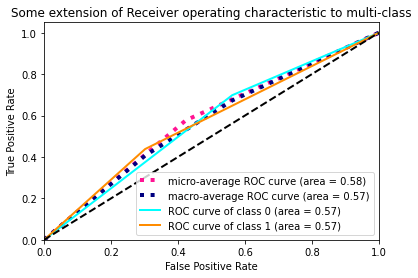

In [ ]:
svm_avg_pred = cross_val_predict(mySVM, clean_data, labels, cv=10)
drawROC(svm_avg_pred)

## Decision Tree

In [ ]:
myTree = tree.DecisionTreeClassifier(class_weight='balanced')
tree_fold = myKFold(myTree, clean_data, labels)

Fold 1 - accuracy: 0.5239691097187819 training_time: 0.9091734886169434 validating_time:  0.008152008056640625
Fold 2 - accuracy: 0.5236776919714411 training_time: 0.877021312713623 validating_time:  0.008195638656616211
Fold 3 - accuracy: 0.5284860848025644 training_time: 0.8944883346557617 validating_time:  0.008237123489379883
Fold 4 - accuracy: 0.5321288066443246 training_time: 0.8766753673553467 validating_time:  0.00814366340637207
Fold 5 - accuracy: 0.5251347807081451 training_time: 0.8769493103027344 validating_time:  0.008123397827148438
Fold 6 - accuracy: 0.5260090339501675 training_time: 0.8889236450195312 validating_time:  0.00800180435180664
Fold 7 - accuracy: 0.5271747049395308 training_time: 0.8632445335388184 validating_time:  0.008259296417236328
Fold 8 - accuracy: 0.5232405653504298 training_time: 0.8767762184143066 validating_time:  0.008107900619506836
Fold 9 - accuracy: 0.5238234008451115 training_time: 0.8907773494720459 validating_time:  0.008430719375610352
Fold

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


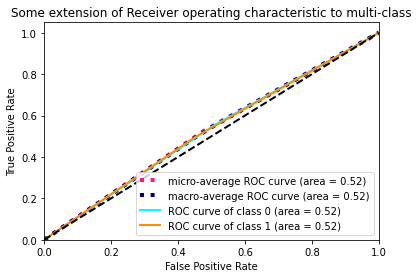

In [ ]:
tree_avg_pred = cross_val_predict(myTree, clean_data, labels, cv=10)
drawROC(tree_avg_pred)

## Neuron Network

In [ ]:
myNN = MLPClassifier(hidden_layer_sizes=(55,55,55), max_iter=1000)
nn_fold = myKFold(myNN, clean_data, labels)

Fold 1 - accuracy: 0.5465539851376949 training_time: 394.4785635471344 validating_time:  0.02513432502746582
Fold 2 - accuracy: 0.5429112632959348 training_time: 313.74776554107666 validating_time:  0.024435997009277344
Fold 3 - accuracy: 0.5397056680751858 training_time: 324.1281931400299 validating_time:  0.025002241134643555
Fold 4 - accuracy: 0.5432026810432755 training_time: 339.98983097076416 validating_time:  0.024265766143798828
Fold 5 - accuracy: 0.5442226431589684 training_time: 249.3323769569397 validating_time:  0.02437305450439453
Fold 6 - accuracy: 0.5547136820632377 training_time: 303.6862668991089 validating_time:  0.02963542938232422
Fold 7 - accuracy: 0.544076934285298 training_time: 289.36636781692505 validating_time:  0.02500319480895996
Fold 8 - accuracy: 0.5427655544222643 training_time: 257.95620465278625 validating_time:  0.02385401725769043
Fold 9 - accuracy: 0.5469911117587061 training_time: 326.08466124534607 validating_time:  0.02434062957763672
Fold 10 - ac

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


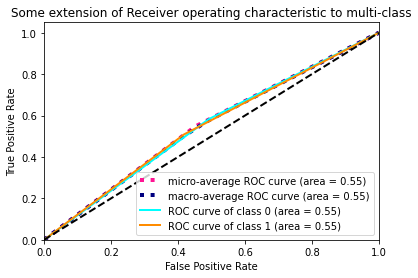

In [ ]:
nn_avg_pred = cross_val_predict(myNN, clean_data, labels, cv=10)
drawROC(nn_avg_pred)

## KNN

In [ ]:
myKNN = KNeighborsClassifier()
param_grid = [{'n_neighbors': [5,7,9,11,13,15]}]
search = GridSearchCV(myKNN, param_grid, cv=10)
search.fit(clean_data, labels)
search.best_params_

{'n_neighbors': 15}

In [ ]:
myKNN = KNeighborsClassifier(n_neighbors=15)
knn_fold = myKFold(myKNN, clean_data, labels)

Fold 1 - accuracy: 0.5443683520326388 training_time: 1.5057649612426758 validating_time:  41.52697968482971
Fold 2 - accuracy: 0.5367914906017777 training_time: 1.6341922283172607 validating_time:  43.62706232070923
Fold 3 - accuracy: 0.5418913011802419 training_time: 1.6105833053588867 validating_time:  43.845635652542114
Fold 4 - accuracy: 0.5432026810432755 training_time: 1.6010289192199707 validating_time:  44.0547878742218
Fold 5 - accuracy: 0.5348972752440624 training_time: 3.0276834964752197 validating_time:  44.669708013534546
Fold 6 - accuracy: 0.536208655107096 training_time: 1.5940546989440918 validating_time:  44.31789207458496
Fold 7 - accuracy: 0.5483024916217397 training_time: 1.6223170757293701 validating_time:  44.49209976196289
Fold 8 - accuracy: 0.5346058574967215 training_time: 1.6092422008514404 validating_time:  44.430325746536255
Fold 9 - accuracy: 0.5423284278012531 training_time: 1.6200809478759766 validating_time:  45.1109778881073
Fold 10 - accuracy: 0.539930

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


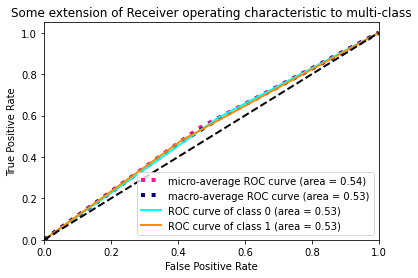

In [ ]:
knn_avg_pred = cross_val_predict(myKNN, clean_data, labels, cv=10)
drawROC(knn_avg_pred)

## Naive Bayesian

In [ ]:
myNB = GaussianNB()
nb_fold = myKFold(myNB, clean_data, labels)

Fold 1 - accuracy: 0.5679731895672446 training_time: 0.053554534912109375 validating_time:  0.008587837219238281
Fold 2 - accuracy: 0.5716159114090048 training_time: 0.05164694786071777 validating_time:  0.008520364761352539
Fold 3 - accuracy: 0.5662246830831997 training_time: 0.052506208419799805 validating_time:  0.010615110397338867
Fold 4 - accuracy: 0.5665161008305406 training_time: 0.05188131332397461 validating_time:  0.01000833511352539
Fold 5 - accuracy: 0.5772985574821506 training_time: 0.05121588706970215 validating_time:  0.008306026458740234
Fold 6 - accuracy: 0.5698674049249599 training_time: 0.0505218505859375 validating_time:  0.008698701858520508
Fold 7 - accuracy: 0.5698674049249599 training_time: 0.051616668701171875 validating_time:  0.01204991340637207
Fold 8 - accuracy: 0.5634562144834621 training_time: 0.0533754825592041 validating_time:  0.009145021438598633
Fold 9 - accuracy: 0.5701588226723008 training_time: 0.060801029205322266 validating_time:  0.00833415985

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


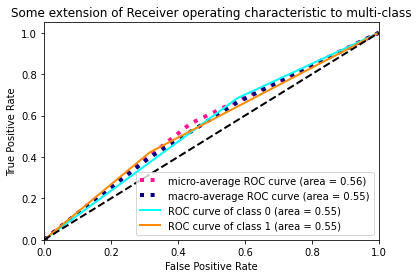

In [ ]:
nb_avg_pred = cross_val_predict(myNB, clean_data, labels, cv=10)
drawROC(nb_avg_pred)

## Random Forest

In [ ]:
myRF = RandomForestClassifier(criterion='gini')
rf_fold = myKFold(myRF, clean_data, labels)

Fold 1 - accuracy: 0.5727815823983681 training_time: 14.847256422042847 validating_time:  0.30054187774658203
Fold 2 - accuracy: 0.565204720967507 training_time: 14.774377346038818 validating_time:  0.30742597579956055
Fold 3 - accuracy: 0.5662246830831997 training_time: 14.761904954910278 validating_time:  0.31222105026245117
Fold 4 - accuracy: 0.5685560250619263 training_time: 14.65726900100708 validating_time:  0.3080933094024658
Fold 5 - accuracy: 0.5687017339355966 training_time: 14.546481609344482 validating_time:  0.30071353912353516
Fold 6 - accuracy: 0.5641847588518141 training_time: 14.602239847183228 validating_time:  0.3039062023162842
Fold 7 - accuracy: 0.5708873670406528 training_time: 14.485925912857056 validating_time:  0.30478382110595703
Fold 8 - accuracy: 0.5640390499781437 training_time: 14.349798679351807 validating_time:  0.30882859230041504
Fold 9 - accuracy: 0.5687017339355966 training_time: 14.607257604598999 validating_time:  0.31382131576538086
Fold 10 - accu

In [ ]:
rf_avg_pred = cross_val_predict(myRF, clean_data, labels, cv=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


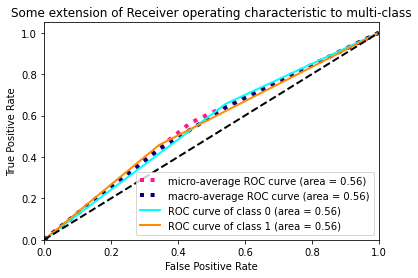

In [ ]:
drawROC(rf_avg_pred)

In [ ]:
from sklearn.feature_selection import chi2
myBest = SelectKBest(chi2, k=20)
ufs_dataset = myBest.fit_transform(clean_data, labels)
mask = myBest.get_support()
new_features = []
for bool, feature in zip(mask, clean_data.columns):
  if bool:
    new_features.append(feature)
ufs_dataset = pd.DataFrame(ufs_dataset, columns=new_features)

In [ ]:
myRF = RandomForestClassifier(criterion='entropy', class_weight='balanced')
rf_fold = myKFold(myRF, ufs_dataset, labels)

Fold 1 - accuracy: 0.5595220748943611 training_time: 4.58943510055542 validating_time:  0.16461634635925293
Fold 2 - accuracy: 0.5586478216523386 training_time: 4.388098478317261 validating_time:  0.169905424118042
Fold 3 - accuracy: 0.5545679731895673 training_time: 4.788499355316162 validating_time:  0.16675186157226562
Fold 4 - accuracy: 0.5506338336004662 training_time: 4.671738386154175 validating_time:  0.17604756355285645
Fold 5 - accuracy: 0.5453883141483317 training_time: 4.871020078659058 validating_time:  0.17479395866394043
Fold 6 - accuracy: 0.5523823400845111 training_time: 4.77167534828186 validating_time:  0.16810345649719238
Fold 7 - accuracy: 0.5560250619262713 training_time: 4.658167600631714 validating_time:  0.16605377197265625
Fold 8 - accuracy: 0.5634562144834621 training_time: 4.656688928604126 validating_time:  0.17029452323913574
Fold 9 - accuracy: 0.5576278595366457 training_time: 4.704559087753296 validating_time:  0.16526460647583008
Fold 10 - accuracy: 0.5

In [ ]:
from sklearn.feature_selection import chi2
myBest = SelectKBest(chi2, k=30)
ufs_dataset = myBest.fit_transform(clean_data, labels)
mask = myBest.get_support()
new_features = []
for bool, feature in zip(mask, clean_data.columns):
  if bool:
    new_features.append(feature)
ufs_dataset = pd.DataFrame(ufs_dataset, columns=new_features)


In [ ]:
myRF = RandomForestClassifier(criterion='entropy')
rf_fold = myKFold(myRF, ufs_dataset, labels)

Fold 1 - accuracy: 0.5370829083491184 training_time: 8.431835889816284 validating_time:  0.28208303451538086
Fold 2 - accuracy: 0.5417455923065715 training_time: 8.500054121017456 validating_time:  0.29422426223754883
Fold 3 - accuracy: 0.5338773131283695 training_time: 8.460800409317017 validating_time:  0.29769444465637207
Fold 4 - accuracy: 0.5328573510126766 training_time: 8.496830940246582 validating_time:  0.28295135498046875
Fold 5 - accuracy: 0.5293603380445869 training_time: 8.442357063293457 validating_time:  0.281888484954834
Fold 6 - accuracy: 0.5442226431589684 training_time: 8.492985725402832 validating_time:  0.2798459529876709
Fold 7 - accuracy: 0.5483024916217397 training_time: 8.501368284225464 validating_time:  0.2784154415130615
Fold 8 - accuracy: 0.5366457817281073 training_time: 8.437949180603027 validating_time:  0.28055596351623535
Fold 9 - accuracy: 0.535480110738744 training_time: 8.49842882156372 validating_time:  0.2872488498687744
Fold 10 - accuracy: 0.5333

# Cross-validation Table

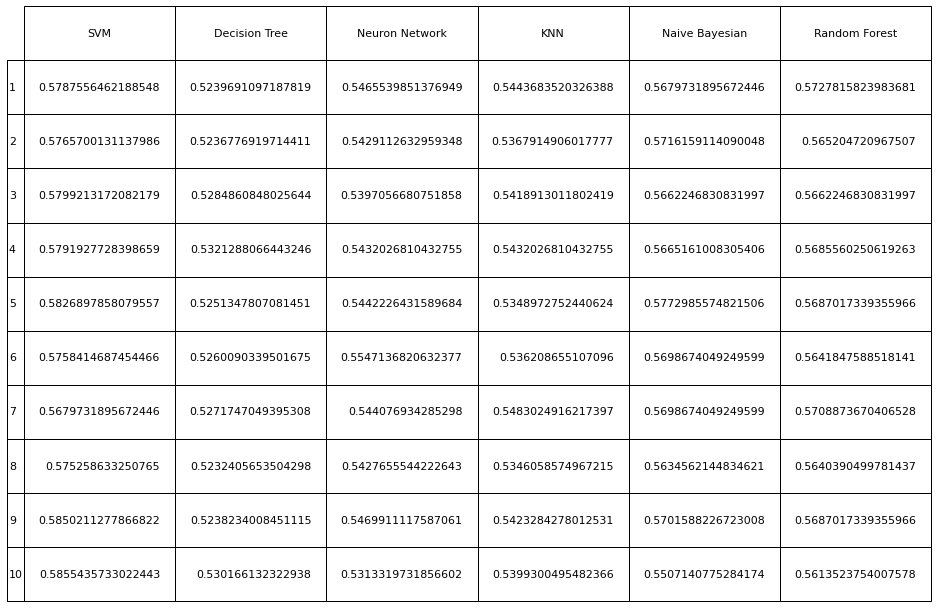

In [ ]:
model_results = []
columns = ['SVM', 'Decision Tree', 'Neuron Network', 'KNN', 'Naive Bayesian', 'Random Forest']

table_data = np.array([svm_fold, tree_fold, nn_fold, knn_fold, nb_fold, rf_fold]).T
            
rows = np.arange(1, 11, 1)
table = plt.table(cellText=table_data, colLabels=columns, rowLabels=rows, loc='center')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table.set_fontsize(24)
table.scale(3,5)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.show()

# Statistically Significant Difference

There are significant differences between  SVM and  DT
There are significant differences between  SVM and  NN
There are significant differences between  SVM and  KNN
There are significant differences between  SVM and  NB
There are significant differences between  SVM and  RF
There are significant differences between  DT and  NN
There are significant differences between  DT and  KNN
There are significant differences between  DT and  NB
There are significant differences between  DT and  RF
No significant differences between  NN and  KNN
There are significant differences between  NN and  NB
There are significant differences between  NN and  RF
There are significant differences between  KNN and  NB
There are significant differences between  KNN and  RF
No significant differences between  NB and  RF


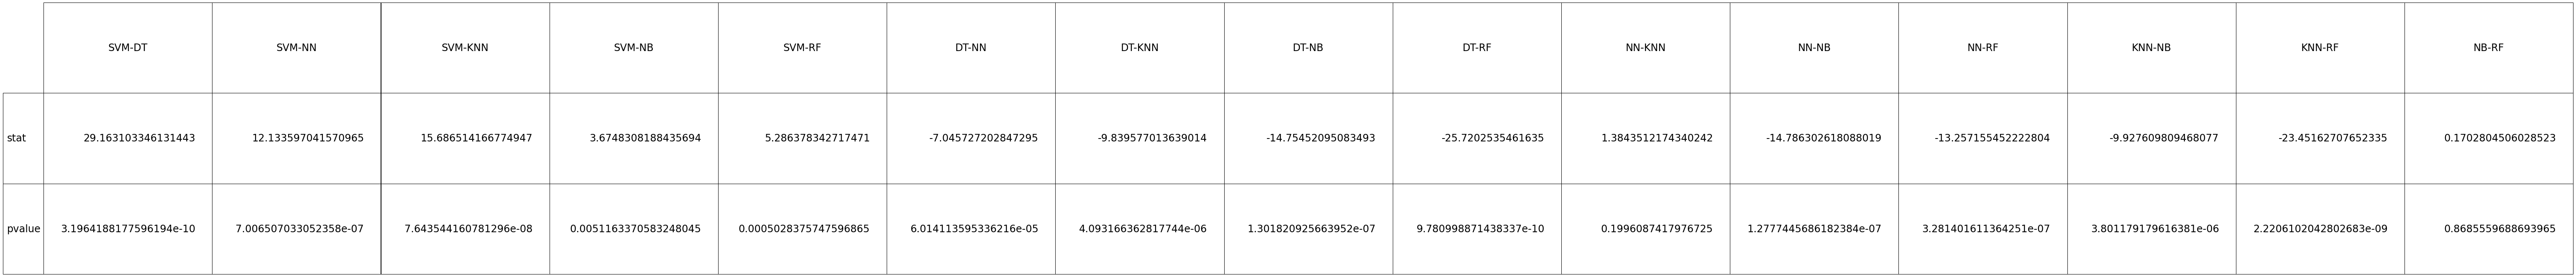

In [ ]:
table_data = table_data.T
columns = ['SVM', 'DT', 'NN', 'KNN', 'NB', 'RF']
results = []
names = []
for i in range(6):
  for j in range(i+1, 6):
    cur_name = columns[i] + "-" + columns[j]
    names.append(cur_name)
    cur_stat, cur_p = ttest_rel(table_data[i], table_data[j])
    if cur_p > 0.05:
      print('No significant differences between ', columns[i], 'and ', columns[j])
    else:
      print('There are significant differences between ', columns[i], 'and ', columns[j])
    results.append([cur_stat, cur_p])

rows = ['stat', 'pvalue']

table = plt.table(cellText=np.transpose(results), colLabels=names, rowLabels=rows, loc='center')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
table.set_fontsize(24)
table.scale(10,10)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.show()

# Feature selection

## Univariate feature selection

In [ ]:
from sklearn.feature_selection import chi2
myBest = SelectKBest(chi2, k=10)
ufs_dataset = myBest.fit_transform(clean_data, labels)
mask = myBest.get_support()
new_features = []
for bool, feature in zip(mask, clean_data.columns):
  if bool:
    new_features.append(feature)
ufs_dataset = pd.DataFrame(ufs_dataset, columns=new_features)

In [ ]:
myRF = RandomForestClassifier(criterion='gini')
rf_fold = myKFold(myRF, ufs_dataset, labels)

Fold 1 - accuracy: 0.5636019233571324 training_time: 2.0424234867095947 validating_time:  0.08969759941101074
Fold 2 - accuracy: 0.5570450240419642 training_time: 2.041417121887207 validating_time:  0.09011244773864746
Fold 3 - accuracy: 0.5542765554422264 training_time: 2.0893733501434326 validating_time:  0.08938455581665039
Fold 4 - accuracy: 0.5676817718199039 training_time: 2.062596082687378 validating_time:  0.08921003341674805
Fold 5 - accuracy: 0.5719073291563456 training_time: 2.0525121688842773 validating_time:  0.09204268455505371
Fold 6 - accuracy: 0.556607897420953 training_time: 2.033506393432617 validating_time:  0.08895993232727051
Fold 7 - accuracy: 0.5606877458837243 training_time: 2.084489583969116 validating_time:  0.0908200740814209
Fold 8 - accuracy: 0.566661809704211 training_time: 2.038330078125 validating_time:  0.08971738815307617
Fold 9 - accuracy: 0.5644761765991549 training_time: 2.0346298217773438 validating_time:  0.08913350105285645
Fold 10 - accuracy: 0

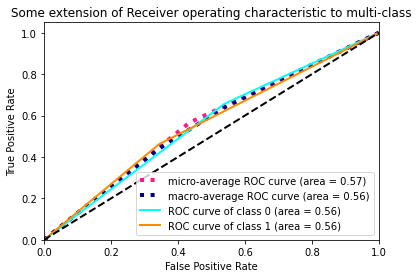

In [ ]:
rf_avg_pred = cross_val_predict(myRF, clean_data, labels, cv=10)
drawROC(rf_avg_pred)

In [ ]:
myKNN = KNeighborsClassifier()
knn_fold = myKFold(myKNN, ufs_dataset, labels)

Fold 1 - accuracy: 0.5280489581815533 training_time: 2.532212972640991 validating_time:  1.8413724899291992
Fold 2 - accuracy: 0.5213463499927146 training_time: 2.5516533851623535 validating_time:  1.8455548286437988
Fold 3 - accuracy: 0.5233862742241002 training_time: 2.469801664352417 validating_time:  1.7813365459442139
Fold 4 - accuracy: 0.5169750837826024 training_time: 2.4668188095092773 validating_time:  1.7862446308135986
Fold 5 - accuracy: 0.5314002622759726 training_time: 2.508476734161377 validating_time:  1.8373055458068848
Fold 6 - accuracy: 0.5267375783185196 training_time: 2.5377707481384277 validating_time:  1.8219029903411865
Fold 7 - accuracy: 0.5209092233717033 training_time: 2.457070827484131 validating_time:  1.798335075378418
Fold 8 - accuracy: 0.5279032493078829 training_time: 2.570002317428589 validating_time:  1.8377597332000732
Fold 9 - accuracy: 0.5404342124435378 training_time: 2.5935778617858887 validating_time:  1.879770040512085
Fold 10 - accuracy: 0.5230

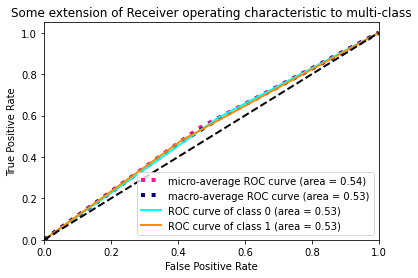

In [ ]:
knn_avg_pred = cross_val_predict(myKNN, clean_data, labels, cv=10)
drawROC(knn_avg_pred)